为了有效地读取数据，对数据进行序列化并将其存储在一组可以线性读取的文件（每个文件100-200MB）中会很有帮助。如果数据正在通过网络流传输，则尤其如此。这对于缓存任何数据预处理也很有用。

TFRecord格式是一种用于存储二进制记录序列的简单格式。

协议缓冲区是用于有效序列化结构化数据的跨平台，跨语言的库。

协议消息由.proto文件定义，这些通常是了解消息类型的最简单方法。

的tf.Example消息（或protobuf的）是一个表示一个灵活的消息类型{"string": value}映射。它旨在与TensorFlow一起使用，并在更高级别的API（例如TFX）中使用。

该笔记本将演示如何创建，解析和使用tf.Example消息，然后tf.Example对.tfrecord文件进行序列化，写入和读取消息。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import IPython.display as display

## 1、消息类型

tf.Example
的数据类型 tf.Example
从根本上讲，a tf.Example是{"string": tf.train.Feature}映射。

该tf.train.Feature消息类型可以接受以下三种类型（参见之一.proto文件以供参考）。大多数其他通用类型可以强制为以下类型之一：

1. tf.train.BytesList （可以强制以下类型）

    * string
    * byte

2. tf.train.FloatList （可以强制以下类型）

    * float（float32）
    * double（float64）
    
3. tf.train.Int64List （可以强制以下类型）

    * bool
    * enum
    * int32
    * uint32
    * int64
    * uint64

为了将标准TensorFlow类型转换为tf.Example-compatible tf.train.Feature，您可以使用下面的快捷功能。请注意，每个函数都采用标量输入值，并返回tf.train.Feature包含上述三种list类型之一的a ：

In [4]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

以下是这些功能如何工作的一些示例。注意变化的输入类型和标准化的输出类型。如果函数的输入类型与上述强制类型之一不匹配，则该函数将引发异常（例如_int64_feature(1.0)，由于1.0是浮点数，因此会出错，因此应与该_float_feature函数一起使用）：

In [5]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



## 2、对消息类型序列化和反序列化

可以使用以下.SerializeToString方法将所有原始消息序列化为二进制字符串：

In [2]:
np.exp(1)

2.718281828459045

In [6]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

建立tf.Example讯息
假设您要tf.Example根据现有数据创建一条消息。实际上，数据集可能来自任何地方，但是tf.Example从单个观察中创建消息的过程将是相同的：

1. 在每次观察中，需要tf.train.Feature使用上述功能之一将每个值转换为包含3种兼容类型之一的值。

1. 您创建了一个从特征名称字符串到＃1中生成的编码特征值的映射（字典）。

1. 在步骤2中生成的地图将转换为Features消息。

在此笔记本中，您将使用NumPy创建数据集。

该数据集将具有4个特征：*布尔特征False或True等概率*均匀地从中随机选择的整数特征[0, 5] *通过使用整数特征作为索引从字符串表生成的字符串特征*来自标准正态分布的浮点特征

考虑一个样本，其中包含来自上述每个分布的10,000个独立且分布相同的观测值：

In [7]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

这些特征的每一个可以被强制转换为tf.Example使用以下之一兼容的类型_bytes_feature，_float_feature，_int64_feature。然后，您可以tf.Example根据以下编码功能创建消息：

In [8]:
def serialize_example(feature0, feature1, feature2, feature3):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

例如，假设您从数据集中获得了一个观测值[False, 4, bytes('goat'), 0.9876]。您可以使用来创建和打印tf.Example此观察的消息create_message()。根据上述内容，每个观察结果都将作为Features消息写入。请注意，该tf.Example 消息只是消息的包装Features：

In [9]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

要解码消息，请使用tf.train.Example.FromString方法。

In [10]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## 3、从消息类型创建tf.data

TFRecord文件使用 tf.data

该tf.data模块还提供了用于在TensorFlow中读取和写入数据的工具。

写入TFRecord文件

将数据获取到数据集中的最简单方法是使用该from_tensor_slices方法。

应用于数组，它返回标量数据集：

In [13]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int32>

适用于数组的元组，它返回元组的数据集：

In [14]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int32, tf.string, tf.float64)>

In [15]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'cat', shape=(), dtype=string)
tf.Tensor(-1.3970017925015354, shape=(), dtype=float64)


## 4、利用tf.data方法系列化消息类型

使用该tf.data.Dataset.map方法将函数应用于的每个元素Dataset。

映射函数必须在TensorFlow图形模式下运行-必须在上运行并返回tf.Tensors。create_example可以包装非张量函数（例如）tf.py_function以使其兼容。

使用tf.py_functionrequire来指定形状和类型信息，否则该信息将不可用：

In [16]:
def tf_serialize_example(f0,f1,f2,f3):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1,f2,f3),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [17]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: id=32, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xf4\xd0\xb2\xbf'>

将此函数应用于数据集中的每个元素：

In [18]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [20]:
def generator():
    for features in features_dataset:
        yield serialize_example(*features)

In [21]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [22]:
serialized_features_dataset

<DatasetV1Adapter shapes: (), types: tf.string>

## 5、写入序列化的文件和读取序列化文件

并将它们写入TFRecord文件：

In [23]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

读取TFRecord文件<br>
您也可以使用tf.data.TFRecordDataset该类读取TFRecord文件。

tf.data可以在此处找到有关使用TFRecord文件的更多信息。

使用TFRecordDatasets对于标准化输入数据和优化性能很有用。

In [24]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [25]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: id=50094, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xf4\xd0\xb2\xbf'>
<tf.Tensor: id=50095, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x92\x95\x02\xc0'>
<tf.Tensor: id=50096, shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04A\xac\x1a\xbf'>
<tf.Tensor: id=50097, shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04E\x87\xe

可以使用下面的函数来解析这些张量。请注意，feature_description这里是必需的，因为数据集使用图形执行，并且需要以下描述来构建其形状和类型签名：

In [26]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
    # Parse the input `tf.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_description)

或者，用于tf.parse example一次解析整个批处理。使用以下tf.data.Dataset.map方法将此函数应用于数据集中的每个项目：

In [27]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

使用急切执行在数据集中显示观测值。此数据集中有10,000个观测值，但您只会显示前10个观测值。数据显示为要素字典。每个项目都是一个tf.Tensor，并且numpy该张量的元素显示要素的值：

In [28]:
for parsed_record in parsed_dataset.take(10):
    print(repr(parsed_record))

{'feature0': <tf.Tensor: id=50135, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=50136, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=50137, shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: id=50138, shape=(), dtype=float32, numpy=-1.3970017>}
{'feature0': <tf.Tensor: id=50139, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=50140, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=50141, shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: id=50142, shape=(), dtype=float32, numpy=-2.040379>}
{'feature0': <tf.Tensor: id=50143, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=50144, shape=(), dtype=int64, numpy=3>, 'feature2': <tf.Tensor: id=50145, shape=(), dtype=string, numpy=b'horse'>, 'feature3': <tf.Tensor: id=50146, shape=(), dtype=float32, numpy=-0.6041909>}
{'feature0': <tf.Tensor: id=50147, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=50148, shape=(), dtype=int64, numpy=2>, 'featu

在这里，该tf.parse_example函数将tf.Example字段解压缩为标准张量。

Python中的TFRecord文件<br>
该tf.io模块还包含用于读取和写入TFRecord文件的纯Python函数。

写入TFRecord文件<br>
接下来，将10,000个观测值写入到文件中test.tfrecord。每个观察结果都将转换为tf.Example消息，然后写入文件。然后，您可以验证文件test.tfrecord是否已创建：

In [29]:
# Write the `tf.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

读取TFRecord文件<br>
这些序列化的张量可以使用tf.train.Example.ParseFromString以下命令轻松解析：

In [30]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [31]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "cat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -1.3970017433166504
      }
    }
  }
}



## 演练：读取和写入图像数据
这是如何使用TFRecords读取和写入图像数据的示例。这样做的目的是演示如何端到端地输入数据（在本例中为图像）并将数据作为TFRecord文件写入，然后读回文件并显示图像。

例如，如果您想在同一输入数据集上使用多个模型，这将很有用。可以将其预处理为TFRecords格式，而不是原始存储图像数据，并且可以将其用于所有进一步的处理和建模中。

首先，让我们下载雪中​​的猫的图像以及正在建设中的纽约威廉斯堡大桥的照片。

获取图像

In [32]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

16384/15477 [===============================] - 0s 5us/step


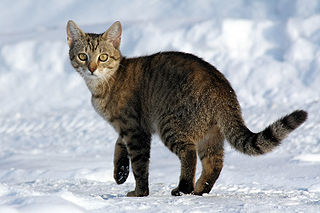

In [33]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

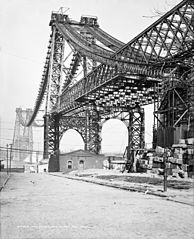

In [34]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

写入TFRecord文件<br>
和以前一样，将要素编码为与兼容的类型tf.Example。这将存储原始图像字符串功能以及高度，宽度，深度和任意label功能。当您编写文件以区分猫图像和桥图像时，将使用后者。使用0了猫的形象，并1为桥梁的图像：

In [35]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [36]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
    print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


请注意，所有功能现在都存储在tf.Example消息中。接下来，对上面的代码进行功能化，并将示例消息写入名为的文件images.tfrecords：

In [37]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for filename, label in image_labels.items():
        image_string = open(filename, 'rb').read()
        tf_example = image_example(image_string, label)
        writer.write(tf_example.SerializeToString())

读取TFRecord文件<br>
现在，您有了文件images.tfrecords-并可以遍历文件中的记录以读回您编写的内容。鉴于在此示例中，您将仅复制图像，所以唯一需要的功能就是原始图像字符串。使用上述吸气剂将其提取example.features.feature['image_raw'].bytes_list.value[0]。您还可以使用标签来确定哪个记录是猫，哪个记录是桥：

In [38]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

从TFRecord文件中恢复图像：

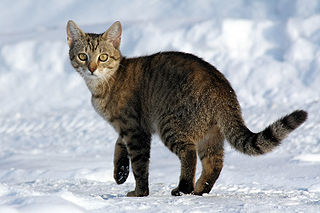

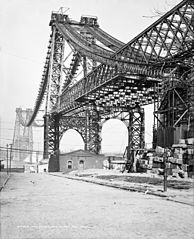

In [39]:
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))